In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation-models

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.metrics import MeanIoU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint #, EarlyStopping
import segmentation_models as sm

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Segmentation Models: using `keras` framework.


In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
train_x_path = "/content/drive/MyDrive/RETINA/TRAIN/image"
train_y_path ="/content/drive/MyDrive/RETINA/TRAIN/mask"
test_x_path = "/content/drive/MyDrive/RETINA/TEST/image"
test_y_path = "/content/drive/MyDrive/RETINA/TEST/mask"

In [ ]:
def read_images(path, i=cv2.IMREAD_COLOR):
    images_array=[]
    for items in sorted(os.listdir(path)):
        img =  cv2.imread(os.path.join(path, items), i)
        img = cv2.resize(img,(256,256))
        images_array.append(img)
    return np.array(images_array[:-1])

In [ ]:
train_x = read_images(train_x_path, i=cv2.IMREAD_COLOR)
train_y = read_images(train_y_path,i=cv2.IMREAD_GRAYSCALE)
test_x = read_images(test_x_path, i=cv2.IMREAD_COLOR)
test_y = read_images(test_y_path, i=cv2.IMREAD_GRAYSCALE)

In [ ]:
train_y = np.expand_dims(train_y, axis=3)
test_y = np.expand_dims(test_y, axis=3)

In [ ]:
print(np.shape(train_x[0]))
print(np.shape(train_y[0]))
print(np.shape(test_x[0]))
print(np.shape(test_y[0]))

(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

train_x = preprocess_input(train_x)
test_x = preprocess_input(test_x)
train_y = train_y.astype(np.float32)/255
test_y = test_y.astype(np.float32)/255

In [ ]:
save_path = '/content/drive/MyDrive/RETINA/model/improvement-{epoch:02d}-{val_accuracy:.2f}-{val_mean_io_u:.2f}.hdf5'
checkpoint = ModelCheckpoint(save_path,monitor='val_accuracy', verbose=1,
                            save_best_onlt=True,mode='max')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list=[checkpoint]#, early]

In [ ]:
model = sm.Unet(BACKBONE, input_shape=(256,256,3), encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=['accuracy',MeanIoU(num_classes=2)])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=20,
    verbose = 1,
    epochs=200,
    validation_data=(test_x, test_y),
    callbacks=callbacks_list
)

Epoch 1/200
2/2 [==============================] - 22s 5s/step - loss: 1.4824 - accuracy: 0.6357 - mean_io_u: 0.4809 - val_loss: 1.9991 - val_accuracy: 0.1197 - val_mean_io_u: 0.4842

Epoch 00001: saving model to /content/drive/MyDrive/RETINA/model/improvement-01-0.12-0.48.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
2/2 [==============================] - 1s 302ms/step - loss: 1.3645 - accuracy: 0.7671 - mean_io_u: 0.4839 - val_loss: 1.4684 - val_accuracy: 0.6726 - val_mean_io_u: 0.4842

Epoch 00002: saving model to /content/drive/MyDrive/RETINA/model/improvement-02-0.67-0.48.hdf5
Epoch 3/200
2/2 [==============================] - 1s 279ms/step - loss: 1.2888 - accuracy: 0.8137 - mean_io_u: 0.4838 - val_loss: 1.7150 - val_accuracy: 0.7269 - val_mean_io_u: 0.4842

Epoch 00003: saving model to /content/drive/MyDrive/RETINA/model/improvement-03-0.73-0.48.hdf5
Epoch 4/200
2/2 [==============================] - 1s 288ms/step - loss: 1.2429 - accuracy: 0.8270 - mean_io_u: 0.4840 - val_loss: 2.2005 - val_accuracy: 0.7391 - val_mean_io_u: 0.4842

Epoch 00004: saving model to /content/drive/MyDrive/RETINA/model/improvement-04-0.74-0.48.hdf5
Epoch 5/200
2/2 [==============================] - 1s 294ms/step - loss: 1.2103 - accuracy: 0.8334 - mean_io_u: 0.4840 - val_loss: 2.5913 - val_accuracy: 0.7

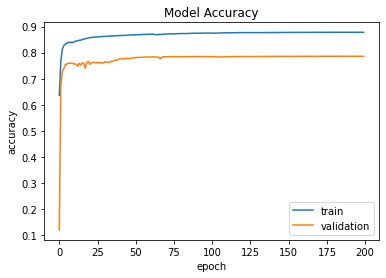

In [ ]:
#  Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

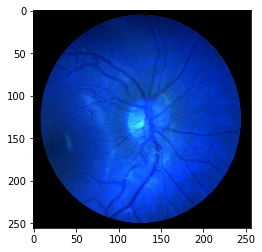

In [ ]:
img =  cv2.imread('/content/drive/MyDrive/RETINA/VALIDATION/Image_12R.jpg', cv2.IMREAD_COLOR) 
test_img = cv2.resize(img, (256,256))
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)

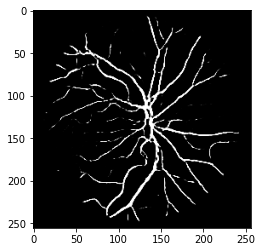

In [ ]:
prediction = model.predict(test_img)
prediction_image = prediction.reshape((256,256))
plt.imshow(prediction_image, cmap='gray')

In [ ]:
model.save('/content/drive/MyDrive/RETINA/retina.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
